# Beamforimng
## Calculating dt
### SeisMicModel class attributes
   - vp: Velocity in km/s.
   - origin: Origin of the model in m as a tuple in (x,y,z) order.
   - spacing: Grid size in m as a Tuple in (x,y,z) order.
   - shape: Number of grid points size in (x,y,z) order.
   - space_order: Order of the spatial stencil discretisation.
   - nbl: The number of absorbin layers for boundary damping.
   - bcs: Absorbing boundary type ("damp" or "mask") or initializer.
   
   ```python
   # User provided dt
   self._dt = kwargs.get('dt')
   # Some wave equation need a rescaled dt that can't be infered from the model
   # parameters, such as isoacoustic OT4 that can use a dt sqrt(3) larger than
   # isoacoustic OT2. This property should be set from a wavesolver or after model
   # instanciation only via model.dt_scale = value.
   self._dt_scale = 1
    
   def _initialize_physics(self, vp, space_order, **kwargs):
       """
       Initialize physical parameters and type of physics from inputs.
       - acoustic: [vp, b]
       """
       params = []
       # Buoyancy
       b = kwargs.get('b', 1)\
       self.vp = self._gen_phys_param(vp, 'vp', space_order)
       # Initialize rest of the input physical parameters
       for name in self._known_parameters:
           if kwargs.get(name) is not None:
               field = self._gen_phys_param(kwargs.get(name), name, space_order)
               setattr(self, name, field)
               params.append(name)
                
    @property
    def _thomsen_scale(self):
        # Update scale for tti
        if 'epsilon' in self._physical_parameters:
            return np.sqrt(1 + 2 * mmax(self.epsilon))
        return 1

    @property
    def dt_scale(self):
        return self._dt_scale

    @dt_scale.setter
    def dt_scale(self, val):
        self._dt_scale = val

    @property
    def _cfl_coeff(self):
        """
        Courant number from the physics and spatial discretization order.
        The CFL coefficients are described in:
        - https://doi.org/10.1137/0916052 for the elastic case
        - https://library.seg.org/doi/pdf/10.1190/1.1444605 for the acoustic case
        """
        a1 = 4  # 2nd order in time
        coeffs = fd_w(2, range(-self.space_order, self.space_order+1), 0)[-1][-1]
        return np.sqrt(a1/float(self.grid.dim * sum(np.abs(coeffs))))

    @property
    def critical_dt(self):
        """
        Critical computational time step value from the CFL condition.
        """
        # For a fixed time order this number decreases as the space order increases.
        #
        # The CFL condtion is then given by
        # dt <= coeff * h / (max(velocity))
        dt = self._cfl_coeff * np.min(self.spacing) / (self._thomsen_scale*self._max_vp)
        dt = self.dtype("%.3e" % (self.dt_scale * dt))
        if self._dt:
            return self._dt
        return dt
   ```

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


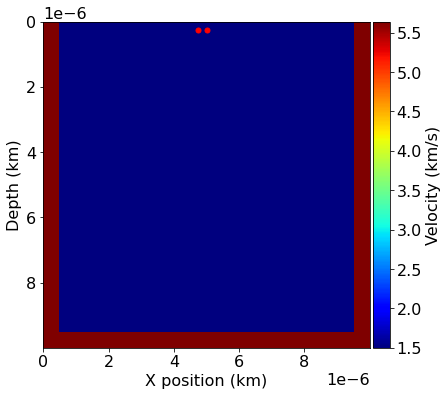

Trying to allocate more memory for symbol u than available on physical device, this will start swapping


factor is 8940
t_sub


RuntimeError: ('Unable to allocate %d elements in memory', '14387687500')

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
from examples.seismic import Receiver
from examples.seismic import RickerSource
from examples.seismic import Model, plot_velocity, TimeAxis
from devito import TimeFunction
from devito import Eq, solve
from devito import Operator
from devito import ConditionalDimension

# Set velocity model
nx = 101
nz = 101
nb = 10
shape = (nx, nz)
spacing = (.0001, .0001)
origin = (0., 0.)
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = 1.5 # v in distilled water 1496.7 m/s
v[:, -5:] = 5.64 # v in glass 5640 m/s
v[:5, :] = 5.64 # v in glass 5640 m/s
v[-5:, :] = 5.64 # v in glass 5640 m/s
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = 10.  # Simulation lasts tn milliseconds
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 5000.  # Source peak frequency is 5MHz (5000 kHz)
ns = 2; # number of sources
source_distance = 0.00025
src = RickerSource(
    name='src',
    grid=model.grid,
    f0=f0,
    time_range=time_range,
    npoint=ns)

for i in range(ns):
    src.coordinates.data[i, :] = np.array(
        model.domain_size) * .5 + (i - ns / 2) * source_distance
    src.coordinates.data[i, -1] = .00025  # Depth is 0.0001 m

plot_velocity(model, source=src.coordinates.data)

#Used for reshaping
vnx = nx+20 
vnz = nz+20

# Using params for snapshotting
nsnaps = 103            # desired number of equally spaced snaps
factor = round(nt / nsnaps)  # subsequent calculated factor
print(f"factor is {factor}")

time_subsampled = ConditionalDimension(
    't_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=2,
                     save=nsnaps, time_dim=time_subsampled)
print(time_subsampled)

# Set symbolics for the wavefield object `u`, setting save on all time steps 
# (which can occupy a lot of memory), to later collect snapshots (naive method):

u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)

# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
# The usual operator would be: op1 = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op2 = Operator([stencil] + src_term + [Eq(usave, u)], subs=model.spacing_map)  # operator with snapshots
# Run the operator for `(nt-2)` time steps:
op2(time=nt - 2, dt=model.critical_dt)

print("Saving snaps file")
print("Dimensions: nz = {:d}, nx = {:d}".format(nz + 2 * nb, nx + 2 * nb))
filename = "snapshots/snaps.bin"
usave.data.tofile(filename)